# Bloch-Redfield Solver: Dissipative Atom-Cavity system

Author: C. Staufenbiel (2022)

with inspirations from the [`brmesolve notebook`](https://github.com/qutip/qutip-notebooks/blob/master/examples/brmesolve.ipynb) by P.D. Nation.

### Introduction

This notebook does not introduce the usage of the Bloch-Redfield solver `qutip.brmesolve()` in detail. For a more detailed introduction to this solver see the [*Bloch-Redfield Solver: Two Level System* notebook](007_brmesolve_tls.md) and the [documentation of the function](https://qutip.readthedocs.io/en/latest/guide/dynamics/dynamics-bloch-redfield.html).

The Lindblad master equation solver, implemented in `qutip.mesolve()`, deals with dissipation using collapse operators which can act on subsystems of the general system. For example, we can define dissipation for the atom-cavity system for the cavity and the atom separately, by the corresponding annihilation operator. In this example, we will see the limitations of this approach when it comes to strong coupling between atom and cavity.

For this example we will use the following Rabi Hamiltonian:

$$H =  \omega_0 a^\dagger a + \omega_0 \sigma_+ \sigma_- + g(a^\dagger + a)(\sigma_- + \sigma_+)$$

We will vary the coupling strength $g$ and compare the results from `qutip.mesolve()` and `qutip.brmesolve()`.


### Imports


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import (about, basis, brmesolve, destroy, identity, ket2dm, mesolve,
                   plot_energy_levels, plot_expectation_values, tensor)

%matplotlib inline



Here we setup as system of a atom-cavity interaction with dissipation to a bath.

In [2]:
N = 10  # num. cavity modes

# operators
a = tensor(destroy(N), identity(2))
sm = tensor(identity(N), destroy(2))

# expectation operators
e_ops = [a.dag() * a, sm.dag() * sm]

# initial state
psi0 = ket2dm(tensor(basis(N, 1), basis(2, 0)))

In the following we setup the frequencies and coupling strength for the atom-cavity system and define the dissipation to the environment. Here we only consider a leaky cavity, i.e. losses to the environment only from the cavity and not from the atom.

In [3]:
w0 = 1.0 * 2 * np.pi
g_weak = 0.1 * 2 * np.pi
g_strong = 0.75 * 2 * np.pi
kappa = 0.05

# collapse operators (for mesolve)
c_ops = [np.sqrt(kappa) * a]
# noise power spectrum (for brmesolve)
a_ops = [[(a + a.dag()), lambda w: kappa * (w > 0)]]

# Hamiltonians
H_no = w0 * a.dag() * a + w0 * sm.dag() * sm
H_weak = w0 * a.dag() * a + w0 * sm.dag() * sm + \
         g_weak * (a + a.dag()) * (sm + sm.dag())
H_strong = w0 * a.dag() * a + w0 * sm.dag() * sm + \
           g_strong * (a + a.dag()) * (sm + sm.dag())

We now solve the dynamics of the atom-cavity interaction using `qutip.mesolve` and `qutip.brmesolve` for the two different coupling strengths.
### Weak coupling

/home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


/home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip/solver/brmesolve.py:173: FutureWarning: c_ops, e_ops, args and options will be keyword only from qutip 5.3
  warnings.warn(


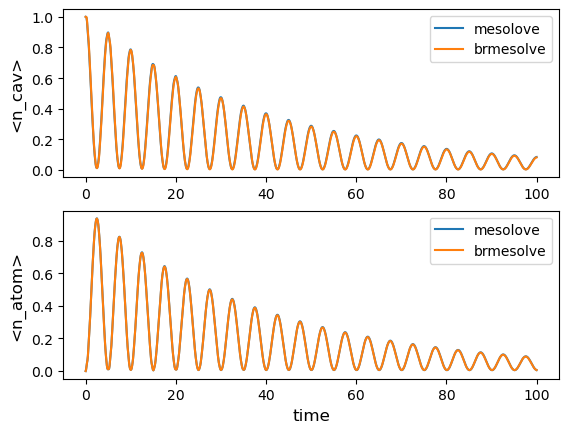

In [4]:
# times for simulation
times = np.linspace(0, 10 * 2 * np.pi / g_weak, 1000)
# simulation
result_me_weak = mesolve(H_weak, psi0, times, c_ops, e_ops)
result_brme_weak = brmesolve(H_weak, psi0, times, a_ops, e_ops)
fig, axes = plot_expectation_values(
    [result_me_weak, result_brme_weak], ylabels=["<n_cav>", "<n_atom>"]
)
for ax in axes:
    ax.legend(['mesolove', 'brmesolve'], loc='upper right')

For the weak coupling strength between atom and cavity we obtain similar results from Lindblad master equation solver `qutip.mesolve` and the Bloch-Redfield solver `qutip.brmesolve`.

### Strong coupling

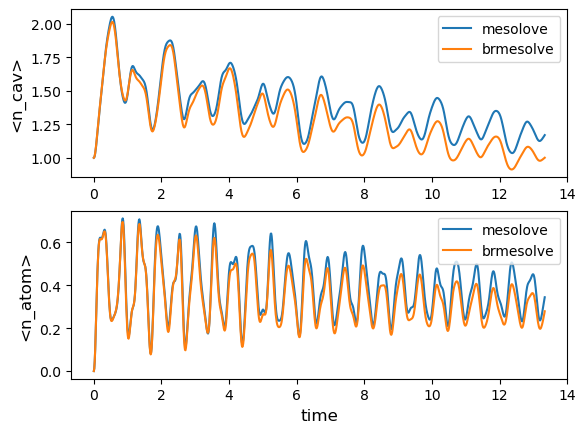

In [5]:
# times for simulation
times = np.linspace(0, 10 * 2 * np.pi / g_strong, 1000)
# simulation
result_me_strong = mesolve(H_strong, psi0, times, c_ops, e_ops)
result_brme_strong = brmesolve(H_strong, psi0, times, a_ops, e_ops)
fig, axes = plot_expectation_values(
    [result_me_strong, result_brme_strong], ylabels=["<n_cav>", "<n_atom>"]
)
for ax in axes:
    ax.legend(['mesolove', 'brmesolve'], loc='upper right')

In the strong coupling regime there are differences in the solution of the two solvers. This is due to the fact that the eigenstates of the system with strong coupling have contributions from atom and the cavity system, i.e. hybridized eigenstates. The Lindbladian master equation solver assumes that the dissipation of a subsystem, here losses in the cavity, does not affect the state of the other subsystem, here the atom. However, for the strongly coupled Hamiltonian this is not true anymore and the dissipation leads to transitions between eigenstates of the coupled system, i.e. also affects the atomic state. By definition the Bloch-Redfield solver takes this hybridization into account and yields the more accurate result for such systems.

We can see this hybridization of the eigenstates from the energy levels. In the system without any interaction, both the atom and the cavity have the same energy levels as we defined them with the similar frequency `w_0`.
For weak interaction the energy levels split up by a small constant, but do not mix up. For strong coupling the energy levels from originally different states bunch together and show the mixing contribution of atom and cavity to the systems eigenstates.

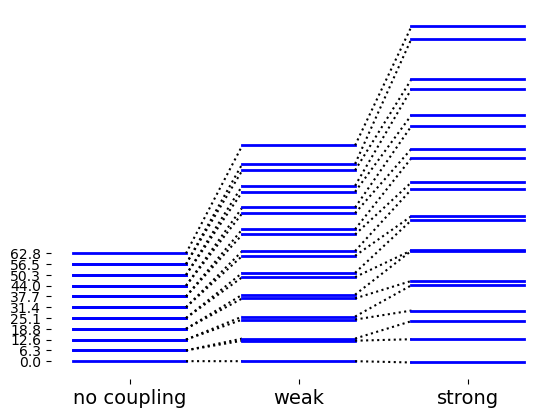

In [6]:
plot_energy_levels([H_no, H_weak, H_strong],
                   h_labels=["no coupling", "weak", "strong"]);

### Non-secular solution
The `qutip.brmesolve()` function automatically uses the secular approximation, i.e. assumes that all fast-oscillating terms in the Hamiltonian can be neglected. However, this approximation is not necessary for the Bloch-Redfield solver and this option can be deactived by setting `sec_cutoff=-1` in the arguments. This setting can be useful in some simulations. For the above example of strongly coupled atom-cavity system, dropping the approximation does not change the solution by much.

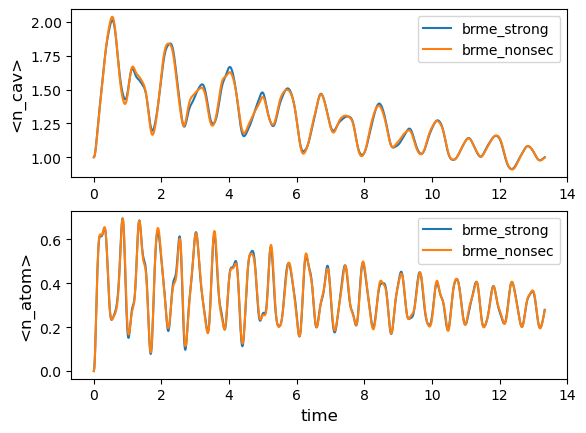

In [7]:
result_brme_nonsec = brmesolve(H_strong, psi0, times, a_ops,
                               sec_cutoff=-1, e_ops=e_ops)
fig, axes = plot_expectation_values(
    [result_brme_strong, result_brme_nonsec], ylabels=["<n_cav>", "<n_atom>"]
)
for ax in axes:
    ax.legend(['brme_strong', 'brme_nonsec'], loc='upper right')

### Trace of states
The Lindbladian Master Equation approach guarantees that the density matrix follows a physical evolution, i.e. the evolution is trace and positivity preserving (up to numerical precision).

A down-side of the Bloch-Redfield solver is that it does not guarantee this physical evolution. Hence the trace of the resulting density matrix can vary. Below we plot the trace of the density matrices for the evolution of the weakly coupled system. The trace of the Bloch-Redfield density matrices slightly deviates from the expected trace $1$ (here: in the range of $10^{-12}$ ). This small deviation was not a problem for the simulation above, but can become a problem for other systems.

Note that the scale of the y-axis is automatically shifted by $+1$ and scaled by $10^{-12}$, which results in the expected trace plotted at $y = 0.0$.

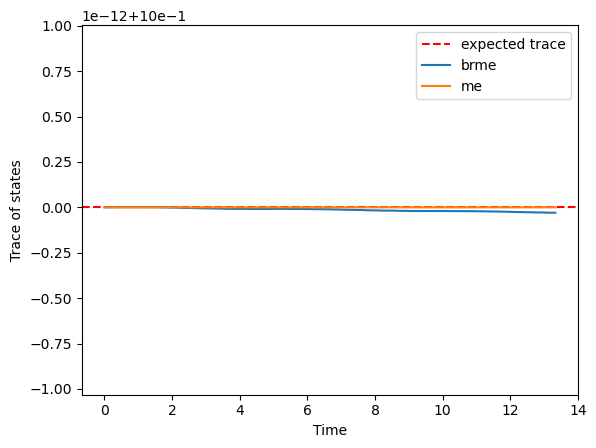

In [8]:
# calculate states for weak coupling
me_states = mesolve(H_weak, psi0, times, c_ops, e_ops=[])
brme_states = brmesolve(H_weak, psi0, times, a_ops, e_ops=[])
# plot the traces and expected trace
plt.axhline(1.0, label="expected trace", c="red", linestyle="--")
plt.plot(times, [state.tr() for state in brme_states.states], label="brme")
plt.plot(times, [state.tr() for state in me_states.states], label="me")
plt.legend(), plt.xlabel("Time"), plt.ylabel("Trace of states");

## About

In [9]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.2.0.dev0+4033695
Numpy Version:      2.2.4
Scipy Version:      1.15.2
Cython Version:     3.0.12
Matplotlib Version: 3.10.1
Python Version:     3.12.0
Number of CPUs:     4
BLAS Info:          Generic
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip

Installed QuTiP family packages
-------------------------------



qutip-jax: 0.1.1.dev5
qutip-qtrl: 0.2.0.dev0+acb71a0
qutip-qip: 0.5.0.dev0+d58a82d

Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`


## Testing

In [10]:
# Weak coupling should be close
assert np.allclose(result_me_weak.expect[0],
                   result_brme_weak.expect[0], atol=0.05)
assert np.allclose(result_me_weak.expect[1],
                   result_brme_weak.expect[1], atol=0.05)

# Strong coupling should not be close
assert not np.allclose(result_me_strong.expect[0],
                       result_brme_strong.expect[0], atol=0.1)
assert not np.allclose(result_me_strong.expect[1],
                       result_brme_strong.expect[1], atol=0.1)

# Trace of states should be approx. 1
assert np.allclose([s.tr() for s in me_states.states],
                   np.ones(times.shape[0]))
assert np.allclose([s.tr() for s in brme_states.states],
                   np.ones(times.shape[0]))